### Tinkering around with initial testing. Mostly, I am trying to answer question (b).

In [105]:


def S_o_change(beta_o, S_o_curr, I_curr_o, I_curr_m):
    return -beta_o*S_o_curr * (I_curr_o + I_curr_m)

def S_m_change(beta_m, S_m_curr, I_curr_o, I_curr_m):
    return -beta_m*S_m_curr * (I_curr_o + I_curr_m)

def R_o_change(k, I_curr_o):
    return k * I_curr_o

def R_m_change(k, I_curr_m):
    return k * I_curr_m

def I_o_change(beta_o, S_o_curr, I_curr_o, I_curr_m, k):
    return (beta_o*S_o_curr * (I_curr_o + I_curr_m)) - (k * I_curr_o)

def I_m_change(beta_m, S_m_curr, I_curr_o, I_curr_m, k):
    return (beta_m*S_m_curr * (I_curr_o + I_curr_m)) - (k * I_curr_m)



In [10]:
import pandas as pd
import numpy as np
import altair as alt

In [3]:
.02 * 2

0.04

In [22]:
S_o = x
S_m = 1 - x - eps
I_m = eps
I_o = 0

In [23]:
S_o_change(B_o, S_o, I_o, I_m)

-0.00016000000000000004

In [24]:
S_o + S_o_change(B_o, S_o, I_o, I_m)

0.79984

In [18]:
S_o

0.8

In [20]:
B_o

0.2

In [21]:
B_m

0.4

In [26]:
S_o[:2]

array([0.8    , 0.79984])

In [ ]:
S_o_change(beta_o=beta_o, S_o)

In [105]:


def S_o_change(beta_o, S_o_curr, I_curr_o, I_curr_m):
    return -beta_o*S_o_curr * (I_curr_o + I_curr_m)

def S_m_change(beta_m, S_m_curr, I_curr_o, I_curr_m):
    return -beta_m*S_m_curr * (I_curr_o + I_curr_m)

def R_o_change(k, I_curr_o):
    return k * I_curr_o

def R_m_change(k, I_curr_m):
    return k * I_curr_m

def I_o_change(beta_o, S_o_curr, I_curr_o, I_curr_m, k):
    return (beta_o*S_o_curr * (I_curr_o + I_curr_m)) - (k * I_curr_o)

def I_m_change(beta_m, S_m_curr, I_curr_o, I_curr_m, k):
    return (beta_m*S_m_curr * (I_curr_o + I_curr_m)) - (k * I_curr_m)



In [167]:
def deriv(beta_o, beta_m, sus_o, sus_m, inf_o, inf_m, k):
    # Ordinary folks first
    ds_o = -beta_o * sus_o * (inf_o + inf_m)
    di_o = (beta_o * sus_o * (inf_o + inf_m)) - k*inf_o
    dr_o = k*inf_o
    
    # Misinfo folks next
    ds_m = -beta_m * sus_m * (inf_o + inf_m)
    di_m = (beta_m * sus_m * (inf_o + inf_m)) - k*inf_m
    dr_m = k*inf_m
    
    return ds_o, di_o, dr_o, ds_m, di_m, dr_m

In [185]:
all_Is = []

In [217]:
def run_simulation(frac_ord, prop_infec, num_days, beta_ord, recovery_days):
    """
    Run an SIR simulation for the indicated number of days based on the
    provided parameters.
    
    NOTE: beta_misinformed always considered to be 2x that of beta_oridiary
        but has a ceiling value of 1.
    
    Parameters:
    -----------
    - frac_ord (float) : the proportion of the population made up of "ordinary"
        individuals. frac_misinformed is 1 - frac_ord
    - prop_infec (float) : the proportion of the population that is initialized
        as infected. This is a subgroup of the misinformed individuals
    - num_days (int) : the number of days to run the simulation for
    - beta_ord (float) : the probability of disease transmission for the ordinary
        individuals. Beta_misinfo = 2*beta_ord
    - recovery_days (int) : the number of days it takes for individuals to recover
    """
    
    eps = prop_infec
    x = frac_ord

    step_size = 1 # step size
    all_steps = np.arange(0, num_days, step_size)

    ### Set initial values ###
    S_o = np.zeros(len(all_steps))
    S_m = np.zeros(len(all_steps))
    I_o = np.zeros(len(all_steps))
    I_m = np.zeros(len(all_steps))
    R_o = np.zeros(len(all_steps))
    R_m = np.zeros(len(all_steps))

    # These have unique values for the first time step
    S_o[0] = x
    S_m[0] = 1 - x - eps
    I_m[0] = eps
    
    # Set recovery rate
    k = 1/recovery_days

    # Setting beta values
    B_o = beta_ord
    B_m = B_o*2
    B_m = 1 if B_m >= 1 else B_m
    
    # Get r0 values
    ord_r0 = B_o/k
    mis_r0 = B_m/k
    weighted_avg_r0 = np.average([ord_r0, mis_r0], weights = [x, 1-x])
    
    r0s = (ord_r0, mis_r0, weighted_avg_r0)

    for t in range(0, len(all_steps)-1):

        # Calculate the change of each value
        d_s_o, d_i_o, d_r_o, d_s_m, d_i_m, d_r_m = deriv(
            beta_o=B_o,
            beta_m=B_m,
            sus_o=S_o[t],
            sus_m=S_m[t],
            inf_o=I_o[t],
            inf_m=I_m[t],
            k=k
        )

        # Ensure that the total change is zero because individuals should
        # simply be shifting between compartments
        total_change = d_s_o + d_s_m + d_i_o + d_i_m + d_r_o + d_r_m
        assert np.allclose(total_change, 0), f"{total_change}"

        # Set the next value as the current plus it's change
        S_o[t+1] = S_o[t] + d_s_o
        S_m[t+1] = S_m[t] + d_s_m
        I_o[t+1] = I_o[t] + d_i_o
        I_m[t+1] = I_m[t] + d_i_m
        R_o[t+1] = R_o[t] + d_r_o
        R_m[t+1] = R_m[t] + d_r_m
    
    return S_o, S_m, I_o, I_m, R_o, R_m, r0s

### Varying $\beta$ values

In [316]:
beta_values = np.arange(.01, 1.01, .01)

totals = []
r0s_ = []

for beta in beta_values:
    S_o, S_m, I_o, I_m, R_o, R_m, r0s = run_simulation(
        frac_ord= .5,
        prop_infec=.001,
        num_days=100,
        beta_ord=beta,
        recovery_days=5
    )
    total_ord_inf = max(R_o)
    total_mis_inf = max(R_m)
    
    r0s_.append(list(r0s)+[beta])
    
    totals.append((total_ord_inf, total_mis_inf, beta))

In [318]:
r_naughts = pd.DataFrame(r0s_, columns = ['ord_r0', 'mis_r0', 'weighted_avg_r0', 'beta'])
r_naughts

,ord_r0,mis_r0,weighted_avg_r0,beta
0,0.05,0.1,0.075,0.01
1,0.10,0.2,0.150,0.02
2,0.15,0.3,0.225,0.03
3,0.20,0.4,0.300,0.04
4,0.25,0.5,0.375,0.05
...,...,...,...,...
95,4.80,5.0,4.900,0.96
96,4.85,5.0,4.925,0.97
97,4.90,5.0,4.950,0.98
98,4.95,5.0,4.975,0.99


In [349]:
r_naughts[r_naughts['weighted_avg_r0'] > 1]['beta'].min()

0.14

In [339]:
melted = r_naughts.melt(id_vars='beta')
melted.variable.unique()

mapper = {
    'ord_r0' : 'ordinary',
    'mis_r0' : 'misinformed',
    'weighted_avg_r0' : 'all'
}

melted.variable = melted.variable.map(mapper)

array(['ord_r0', 'mis_r0', 'weighted_avg_r0'], dtype=object)

In [330]:
totals_frame = pd.DataFrame(totals, columns = ['total_ord_inf', 'total_mis_inf', 'beta'])

totals_frame['total'] = totals_frame['total_ord_inf'] + totals_frame['total_mis_inf']

totals_frame

,total_ord_inf,total_mis_inf,beta,total
0,0.000027,0.001054,0.01,0.001081
1,0.000059,0.001117,0.02,0.001176
2,0.000097,0.001193,0.03,0.001290
3,0.000143,0.001285,0.04,0.001428
4,0.000200,0.001399,0.05,0.001598
...,...,...,...,...
95,0.498561,0.498949,0.96,0.997509
96,0.498676,0.498956,0.97,0.997632
97,0.498783,0.498963,0.98,0.997746
98,0.498882,0.498970,0.99,0.997852


In [336]:
melted_totals = totals_frame.melt(id_vars = 'beta')
melted_totals

,beta,variable,value
0,0.01,total_ord_inf,0.000027
1,0.02,total_ord_inf,0.000059
2,0.03,total_ord_inf,0.000097
3,0.04,total_ord_inf,0.000143
4,0.05,total_ord_inf,0.000200
...,...,...,...
295,0.96,total,0.997509
296,0.97,total,0.997632
297,0.98,total,0.997746
298,0.99,total,0.997852


In [337]:
mapper = {
    "total_ord_inf" : "ordinary",
    "total_mis_inf" : "misinformed",
    "total" : "all",
}

melted_totals.variable = melted_totals.variable.map(mapper)

melted_totals.beta = np.round(melted_totals.beta, 2)

In [379]:
rule_text_df = pd.DataFrame({
    'x' : [r_naughts[r_naughts['weighted_avg_r0'] > 1]['beta'].min()],
    'y1' : [0],
    'y2' : [2.5],
    'text' : [f"R0 > 1 ({r_naughts[r_naughts['weighted_avg_r0'] > 1]['beta'].min()})"]
})

r0_fig = alt.Chart(melted).mark_point(color='black', size = 50).encode(
    x = alt.X('beta:Q', title=None),
    y = alt.Y("value:Q", title = "R0"),
    shape = alt.Y("variable:N")
).properties(width=600, height=200) + alt.Chart(rule_text_df).mark_rule(color = 'red').encode(
    x = 'x:Q',
    y = 'y1:Q',
    y2 = 'y2:Q'
) + alt.Chart(rule_text_df).mark_text(
    dx=-25,
    dy=-10,
    fontSize=15
).encode(
    x = 'x:Q',
    y = 'y2:Q',
    text = 'text'
)

r0_fig

alt.LayerChart(...)

In [393]:
beta_fig = alt.Chart(melted_totals).mark_point(color='black', size=50).encode(
    x = alt.X(
        "beta:Q",
        axis = alt.Axis(
            title = ['beta_o', '(beta_m = 2*beta_o)'],
        ),
#         scale = alt.Scale(range=(0,1))
    ),
    y = alt.Y("value:Q", title='Total proportion infected'),
    shape = alt.Shape("variable:N", title='population')
).properties(width=600)


both = alt.vconcat(r0_fig, beta_fig)

both.configure_axis(
    titleFontSize=15,
    labelFontSize=14,
    labelAngle=0
).configure_legend(
    titleFontSize=15,
    labelFontSize=14,
)

alt.VConcatChart(...)

In [223]:
max(R_o)

0.4799044705681146

In [224]:
max(R_m)

0.49843998279884044

In [230]:
def get_peak_day(infected_array):
    return np.where(np.array(infected_array) == max(infected_array))[0][0]

In [232]:
peak_day_ord = get_peak_day(I_o)
peak_val_ord = max(I_o)

peak_day_mis = get_peak_day(I_m)
peak_val_mis = max(I_m)

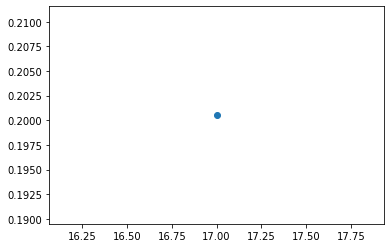

In [233]:
plt.scatter(peak_day_ord, peak_val_ord)

In [231]:
get_peak_day(I_o)

17

In [225]:
np.where(np.array(I_o) == max(I_o))

(array([17]),)

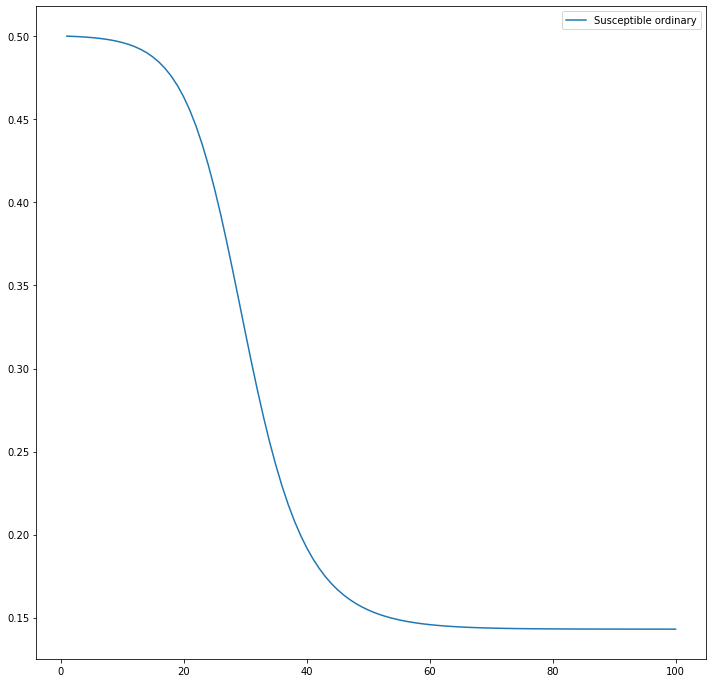

In [219]:
plt.figure(figsize=(12,12))

plt.plot(range(1,len(S_o)+1), S_o, label=f'Susceptible ordinary')

plt.legend()

In [203]:
eps = 0.001 # Fraction of initially 'misinformed'
x = .5       # Fraction of 'ordinary'

step_size = 1 # step size
all_steps = np.arange(0,100,step_size)
print(f"num time steps = {len(all_steps)}")

### Set initial values ###
S_o = np.zeros(len(all_steps))
S_m = np.zeros(len(all_steps))
I_o = np.zeros(len(all_steps))
I_m = np.zeros(len(all_steps))
R_o = np.zeros(len(all_steps))
R_m = np.zeros(len(all_steps))

# These have unique values for the first time step
S_o[0] = x
S_m[0] = 1 - x - eps
I_m[0] = eps

recovery_days = 5
k = 1/recovery_days

# Setting beta values
B_o = .3
B_m = B_o*2
B_m = 1 if B_m > 1 else B_m
print("beta_o", B_o)
print("beta_m", B_m)
avg_beta = (B_o+B_m)/2
print('avg beta', avg_beta)
print('k',k)
print('R_0',avg_beta/k)
print("~~~")

print( (((B_o/k)*x) + ((B_m/k)*1-x)/2) )
print(B_o/k)
print(B_m/k)


for t in range(0, len(all_steps)-1):
    
    # Calculate the change of each value
    d_s_o, d_i_o, d_r_o, d_s_m, d_i_m, d_r_m = deriv(
        beta_o=B_o,
        beta_m=B_m,
        sus_o=S_o[t],
        sus_m=S_m[t],
        inf_o=I_o[t],
        inf_m=I_m[t],
        k=k
    )
    
    # Ensure that the total change is zero because individuals should
    # simply be shifting between compartments
    total_change = d_s_o + d_s_m + d_i_o + d_i_m + d_r_o + d_r_m
    assert np.allclose(total_change, 0), f"{total_change}"
    
    # Set the next value as the current plus it's change
    S_o[t+1] = S_o[t] + d_s_o
    S_m[t+1] = S_m[t] + d_s_m
    I_o[t+1] = I_o[t] + d_i_o
    I_m[t+1] = I_m[t] + d_i_m
    R_o[t+1] = R_o[t] + d_r_o
    R_m[t+1] = R_m[t] + d_r_m
    

    
all_results = np.stack([
    S_o, S_m, I_o, I_m, R_o, R_m
]).T

df = pd.DataFrame(
    all_results,
    columns = [
        'susceptible_ord',
        'susceptible_misinfo',
        'infected_ord',
        'infected_misinfo',
        'recovered_ord',
        'recovered_misinfo',
    ]
)

df['steps'] = np.arange(1, len(all_steps)+1, 1)

# df = df[['steps','infected_ord','infected_misinfo']]

# df['all_infected'] = df['infected_ord'] + df['infected_misinfo']

alt.Chart(df.melt(id_vars='steps')).mark_line().encode(
    x = alt.X(
        'steps:Q',
        title = ["Days", f"(estimated with stepsize = {step_size})"]
    ),
    y = alt.Y(
        'value:Q',
        title = "Proportion of poulation"
    ),
    color = alt.Color(
        'variable:N'
    )
).properties(width=700, height=300)

all_Is.append((I_o, B_o))

num time steps = 100
beta_o 0.3
beta_m 0.6
avg beta 0.44999999999999996
k 0.2
R_0 2.2499999999999996
~~~
1.9999999999999996
1.4999999999999998
2.9999999999999996


In [205]:
ord_r0 = B_o/k
mis_r0 = B_m/k

In [214]:
x = .7

np.average([ord_r0, mis_r0], weights = [x, 1-x])

1.9499999999999997

In [201]:
x

1

In [207]:
ord_r0

1.4999999999999998

In [208]:
mis_r0

2.9999999999999996

In [215]:
((ord_r0*x) + (mis_r0*(1-x))) /1

1.9499999999999997

In [216]:
np.mean([ord_r0, mis_r0])

2.2499999999999996

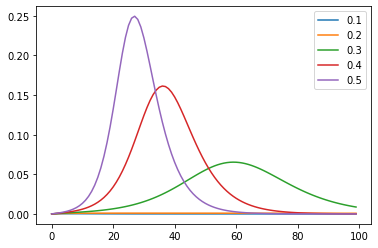

In [192]:
for data, beta in all_Is:
    plt.plot(all_steps, data, label=f'{beta}')

plt.legend()

In [176]:
max(np.cumsum(I_o)) + max(np.cumsum(I_m))

4.585751575286377

In [193]:
max(R_o) + max(R_m)

0.906883991349595

In [181]:
I_o

2.130496696386928

In [113]:
I_o[-1] + I_m[-1]

6.365563716763522e-07

In [68]:
np.round(S_o[:5], 2)

array([ 5.00000000e+02,  4.75000000e+02, -1.32763000e+03,  3.49642920e+05,
        3.33993761e+10])

In [64]:
S_o = pop_size * x
S_m = pop_size * (1 - x - eps)
I_m = pop_size * eps
I_o = 0


In [65]:
S_o_change(B_o, S_o, I_o, I_m)

-25.0

In [159]:
def deriv(beta, sus, inf, gamma, N):
    ds = (-beta * sus * inf)/ N
    di = ((beta * sus * inf)/N) - gamma*inf
    dr = gamma*inf
    return ds, di, dr

In [160]:
# Total population, N.
N = 1000
# Initial number of infected and recovered individuals, I0 and R0.
I0, R0 = 1, 0
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0
# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
beta, gamma = 0.2, 1./10 

step_size = .01 # step size
all_steps = np.arange(0,100,step_size)

I = [I0] + list(np.zeros(len(all_steps)-1))
R = [R0] + list(np.zeros(len(all_steps)-1))
S = [S0] + list(np.zeros(len(all_steps)-1))


In [161]:
step_size

0.01

In [162]:
len(all_steps)

10000

In [93]:
len(I)

100

In [163]:


for step in range(len(all_steps)-1):
    
    ds, di, dr = deriv(beta, S[step], I[step], gamma, N)
    
    S[step+1] = S[step] + ds*step_size
    I[step+1] = I[step] + di*step_size
    R[step+1] = R[step] + dr*step_size
    

In [164]:
S

[999,
 998.998002,
 998.996002009996,
 998.9940000280179,
 998.9919960520938,
 998.9899900802498,
 998.9879821105098,
 998.9859721408965,
 998.9839601694298,
 998.9819461941282,
 998.9799302130082,
 998.9779122240842,
 998.9758922253687,
 998.9738702148725,
 998.971846190604,
 998.9698201505701,
 998.9677920927754,
 998.9657620152229,
 998.9637299159134,
 998.9616957928457,
 998.9596596440168,
 998.9576214674217,
 998.9555812610535,
 998.9535390229031,
 998.9514947509598,
 998.9494484432106,
 998.9474000976408,
 998.9453497122335,
 998.94329728497,
 998.9412428138295,
 998.9391862967893,
 998.9371277318248,
 998.9350671169093,
 998.9330044500141,
 998.9309397291086,
 998.9288729521601,
 998.9268041171341,
 998.924733221994,
 998.9226602647011,
 998.920585243215,
 998.9185081554931,
 998.9164289994908,
 998.9143477731616,
 998.912264474457,
 998.9101791013262,
 998.9080916517169,
 998.9060021235744,
 998.9039105148421,
 998.9018168234616,
 998.8997210473722,
 998.8976231845112,
 998.895

In [97]:
import matplotlib.pyplot as plt

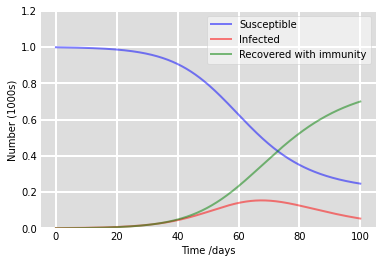

In [165]:
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(all_steps, np.array(S)/1000, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(all_steps, np.array(I)/1000, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(all_steps, np.array(R)/1000, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
ax.set_xlabel('Time /days')
ax.set_ylabel('Number (1000s)')
ax.set_ylim(0,1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)

In [5]:


def S_o_change(beta_o, S_o_curr, I_curr_o, I_curr_m):
    return -beta_o*S_o_curr * (I_curr_o + I_curr_m)

def S_m_change(beta_m, S_m_curr, I_curr_o, I_curr_m):
    return -beta_m*S_m_curr * (I_curr_o + I_curr_m)

def R_o_change(k, R_o_curr):
    return k * R_o_curr

def R_m_change(k, R_m_curr):
    return k * R_m_curr

def I_o_change(beta_o, S_o_curr, I_curr_o, I_curr_m, k, R_o_curr):
    return (beta_o*S_o_curr * (I_curr_o + I_curr_m)) - (k * R_o_curr)

def I_m_change(beta_m, S_m_curr, I_curr_o, I_curr_m, k, R_m_curr):
    return (beta_m*S_m_curr * (I_curr_o + I_curr_m)) - (k * R_m_curr)



In [ ]:
def deriv(beta_o, beta_m, sus_o, sus_m, inf_o, inf_m, k, N):
    # Ordinary folks first
    ds_o = (-beta * sus_o * (inf_o + inf_m))/ N
    di_o = ((beta * sus_o * (inf_o + inf_m))/N) - k*inf_o
    dr_o = k*inf_o
    
    # Misinfo folks next
    ds_m = (-beta * sus_m * (inf_o + inf_m))/ N
    di_m = ((beta * sus_m * (inf_o + inf_m))/N) - k*inf_m
    dr_m = k*inf_m
    
    return ds_o, di_o, dr_o, ds_m, di_m, dr_m